# Import Libraries

In [1]:
import cPickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from cifar import *
%matplotlib inline

In [2]:
def Wstar(cov_x, cov_yx):
    if cov_x.any():
        cov_x_inv = np.linalg.pinv(cov_x)
    else:
        cov_x_inv = cov_x
    W = np.dot(cov_yx, cov_x_inv)
    return W

def mmseEstimator(x, u_x, u_y, cov_x, cov_yx):
    W = Wstar(cov_x, cov_yx)
    dist = x - u_x.reshape((u_x.shape[0]), 1)
    return np.dot(W, dist) + u_y.reshape((u_y.shape[0]), 1)

# get statistics for mmse
def getStatistics(data, vectorMask):
    # get mean and covariance of original data
    mean = np.mean(data, axis=1)
    cov = np.cov(data)
    
    # get indices for X, Y parts of data
    x_idx = np.where([vectorMask == 1])[1]
    y_idx = np.where([vectorMask == 0])[1]
        
    # apply masks
    u_x = mean[x_idx]
    u_y = mean[y_idx]
    cov_x = cov[x_idx]
    cov_x = cov_x[:, x_idx]
    cov_yx = cov[y_idx]
    cov_yx = cov_yx[:, x_idx]
    cov_y = cov[y_idx]
    cov_y = cov_y[:, y_idx]
    
    # return statistics
    return u_x, u_y, cov_x, cov_yx

# Get CIFAR data (also define mask)

In [3]:
# get datasets
train, test, train_labels, test_labels = returnCIFARdata()

----CIFAR10 dataset loaded----
Train data: 3072 x 50000
Test data: 3072 x 10000


In [4]:
# define number of columns or square size to remove
nCols = 0
squareLength = 8

if (nCols == 0):
    vecMask = generateCenterSquareMask(squareLength)
    train_hidden, Xtrain, Ytrain, \
    test_hidden, Xtest, Ytest = returnSquareData(squareLength)

else:
    vecMask = generateColumnMask(nCols)
    train_hidden, Xtrain, Ytrain, \
    test_hidden, Xtest, Ytest = returnHalfData(nCols)

x_idx = np.where([vecMask == 1])[1]
y_idx = np.where([vecMask == 0])[1]

----CIFAR10 dataset loaded----
Train data: 3072 x 50000
Test data: 3072 x 10000


# MMSE Affine Estimator

In [5]:
# do mmse estimation
u_x, u_y, cov_x, cov_yx = getStatistics(train, vecMask)
Ytrain_hat = mmseEstimator(Xtrain, u_x, u_y, cov_x, cov_yx)
Ytest_hat = mmseEstimator(Xtest, u_x, u_y, cov_x, cov_yx)

# calculate mse per hidden pixel for train
diff_train = Ytrain - Ytrain_hat
numTrain = Ytrain.shape[1]
trainMSEs = np.zeros(numTrain)
for j in range(numTrain):
    trainMSEs[j] = np.mean(np.multiply(diff_train[:, j], diff_train[:, j]))
train_MSE = np.mean(trainMSEs)

# calculate mse per hidden pixel for test
diff_test = Ytest - Ytest_hat
numTest = Ytest.shape[1]
testMSEs = np.zeros(numTest)
for j in range(numTest):
    testMSEs[j] = np.mean(np.multiply(diff_test[:, j], diff_test[:, j]))
test_MSE = np.mean(testMSEs)

print "Train MSE: %g" %train_MSE
print "Test MSE: %g" %test_MSE

train_affine = np.copy(train)
train_affine[y_idx] = Ytrain_hat

test_affine = np.copy(test)
test_affine[y_idx] = Ytest_hat

Train MSE: 0.0143137
Test MSE: 0.0163497


In [ ]:
# np.save('test_affine.npy', train_affine)
# np.save('train_affine.npy', train_affine)

# load precomputed affine data
# test_affine = np.load('test_affine.npy')
# train_affine = np.load('train_affine.npy')

# Get Autoencoder Generated Data

In [8]:
# Load cnn predicted train and test data
# if the network generates something in the space of the whole image, uncomment [y_idx]

pathStr = "CIFAR_sample_generations_playing"
print 'Columns: %d' %nCols
print 'Square Length: %d' %squareLength

if (nCols == 0):
    predicted_train = np.load('%s/predictedTrain_cifar_square_%d.npy' %(pathStr, squareLength))
    predicted_test = np.load('%s/predictedTest_cifar_square_%d.npy' %(pathStr, squareLength))
else:
    predicted_train = np.load('%s/predictedTrain_cifar_ncols_%d.npy' %(pathStr, nCols))
    predicted_test = np.load('%s/predictedTest_cifar_ncols_%d.npy' %(pathStr, nCols))
# predicted_train = np.load('predictedTrain_cifar_squareAdv_16.npy')
# predicted_test = np.load('predictedTest_cifar_squareAdv_16.npy')


print predicted_train.shape
print predicted_test.shape

# sanity check mses for unknown portion of image
# calculate mse per hidden pixel for train
Ytrain_ae_hat = predicted_train[y_idx]
Ytest_ae_hat = predicted_test[y_idx]

# calculate mse per hidden pixel for train
diff_train = Ytrain - Ytrain_ae_hat
numTrain = Ytrain.shape[1]
trainMSEs = np.zeros(numTrain)
for j in range(numTrain):
    trainMSEs[j] = np.mean(np.multiply(diff_train[:, j], diff_train[:, j]))
train_MSE = np.mean(trainMSEs)

# calculate mse per hidden pixel for test
diff_test = Ytest - Ytest_ae_hat
numTest = Ytest.shape[1]
testMSEs = np.zeros(numTest)
for j in range(numTest):
    testMSEs[j] = np.mean(np.multiply(diff_test[:, j], diff_test[:, j]))
test_MSE = np.mean(testMSEs)

print "Train MSE: %g" %train_MSE
print "Test MSE: %g" %test_MSE

train_nn = np.copy(train)
train_nn[y_idx] = predicted_train[y_idx]

test_nn = np.copy(test)
test_nn[y_idx] = predicted_test[y_idx]

train_genOutput = convert_images(predicted_train)
test_genOutput = convert_images(predicted_test)

Columns: 0
Square Length: 8
(3072, 50000)
(3072, 10000)
Train MSE: 0.0113795
Test MSE: 0.0173804


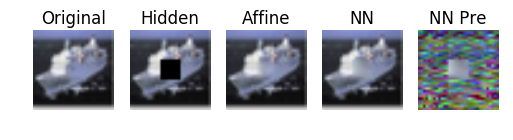

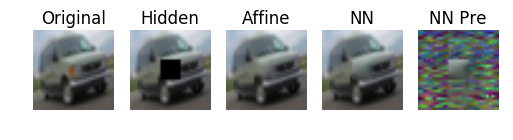

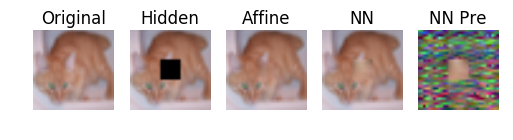

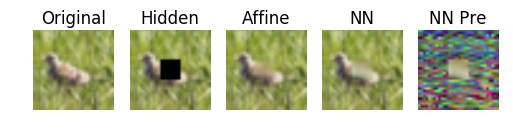

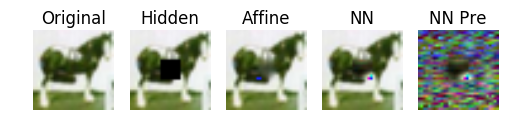

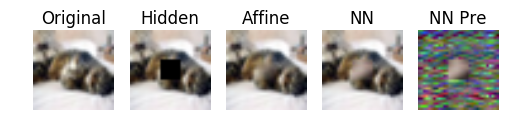

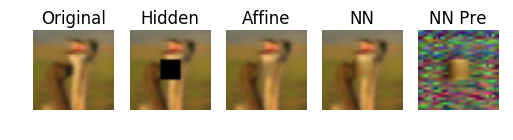

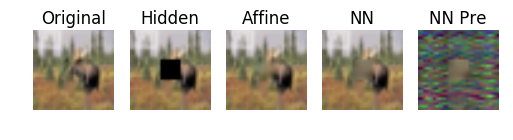

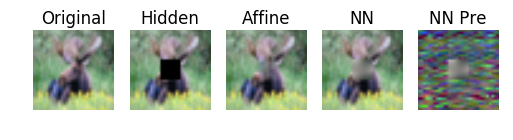

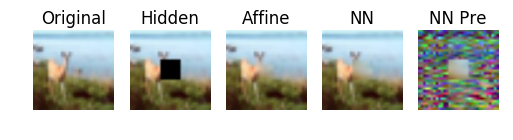

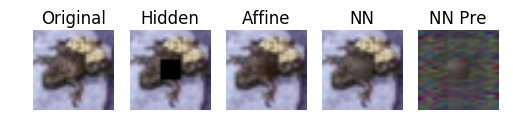

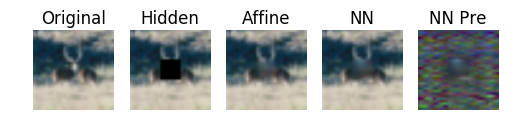

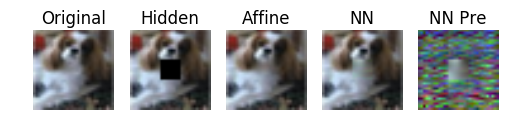

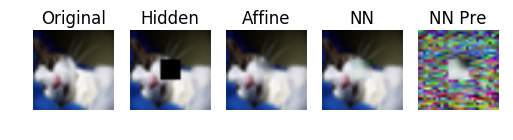

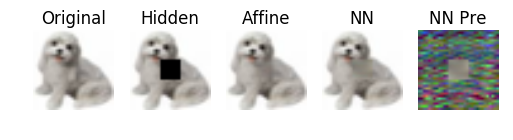

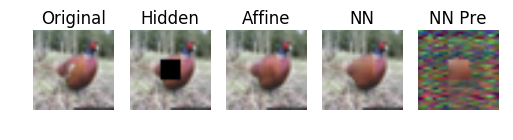

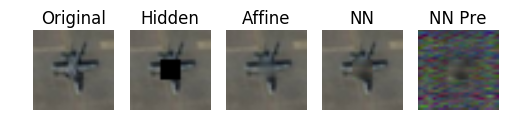

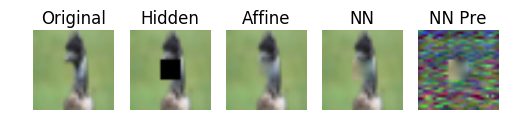

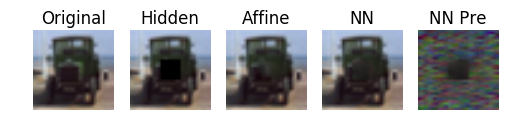

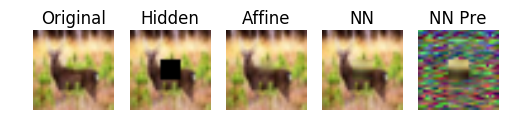

In [9]:
for i in range(20):
    random = np.random.randint(0, 50000)    

    # original image
    original = train[:, random]
    originalImg = convert_images(original)

    # hidden image
    hidden = train_hidden[:, random]
    hiddenImg = convert_images(hidden)
    
    # approximated image
    approx = train_affine[:, random]
    approxImg = convert_images(approx)
    
    # nn image (overlayed)
    nn = train_nn[:, random]
    nnImg = convert_images(nn)
    
    # nn image (pre overlaying)
    nn_full = predicted_train[:, random]
    nnImg_full = convert_images(nn_full)

    # plot
    plt.figure(i); 
    plt.subplot(1, 5, 1); plt.imshow(originalImg[:, :, :, 0]); plt.title('Original'); plt.axis('off')
    plt.subplot(1, 5, 2); plt.imshow(hiddenImg[:, :, :, 0]); plt.title('Hidden'); plt.axis('off')
    plt.subplot(1, 5, 3); plt.imshow(approxImg[:, :, :, 0]); plt.title('Affine'); plt.axis('off')
    plt.subplot(1, 5, 4); plt.imshow(nnImg[:, :, :, 0]); plt.title('NN'); plt.axis('off')
    plt.subplot(1, 5, 5); plt.imshow(nnImg_full[:, :, :, 0]); plt.title('NN Pre'); plt.axis('off')
    # plt.savefig('cifar_gen_%d' %i)

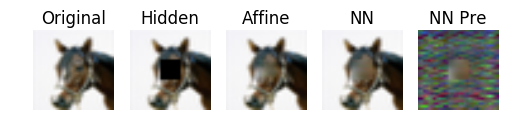

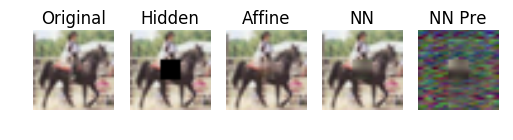

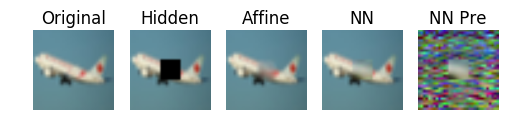

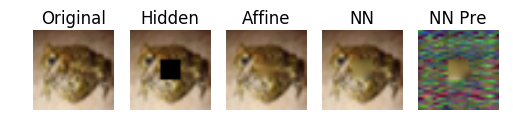

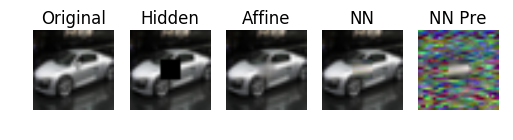

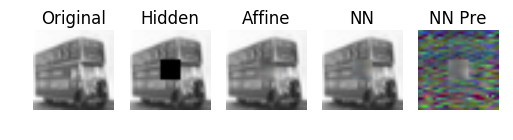

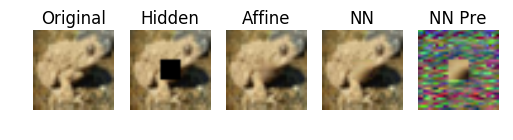

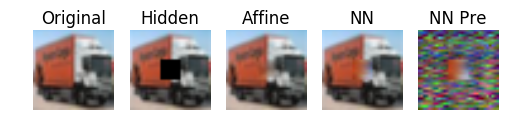

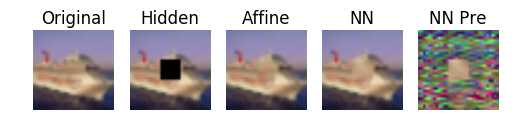

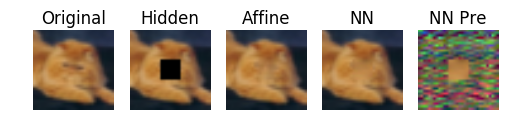

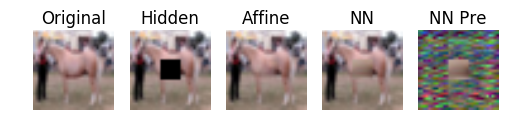

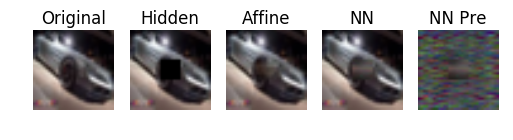

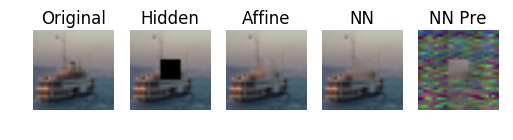

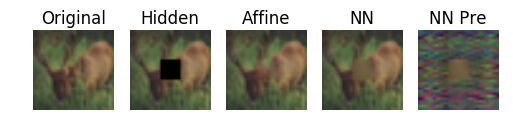

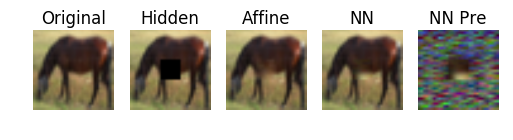

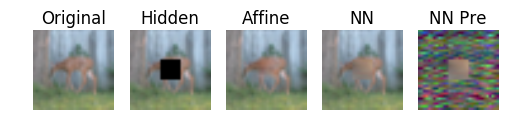

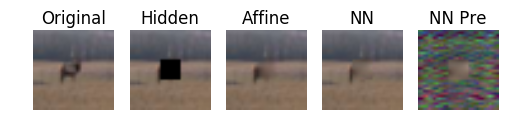

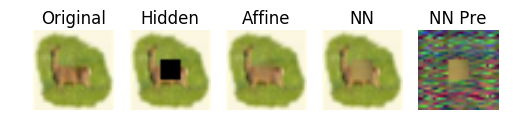

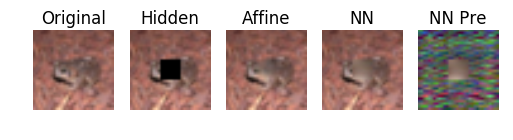

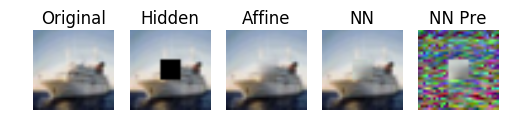

In [10]:
for i in range(20):
    random = np.random.randint(0, 10000)    

    # original image
    original = test[:, random]
    originalImg = convert_images(original)

    # hidden image
    hidden = test_hidden[:, random]
    hiddenImg = convert_images(hidden)
    
    # approximated image
    approx = test_affine[:, random]
    approxImg = convert_images(approx)
    
    # nn image (overlayed)
    nn = test_nn[:, random]
    nnImg = convert_images(nn)

    # nn image (pre overlaying)
    nn_full = predicted_test[:, random]
    nnImg_full = convert_images(nn_full)

    # plot
    plt.figure(i); 
    plt.subplot(1, 5, 1); plt.imshow(originalImg[:, :, :, 0]); plt.title('Original'); plt.axis('off')
    plt.subplot(1, 5, 2); plt.imshow(hiddenImg[:, :, :, 0]); plt.title('Hidden'); plt.axis('off')
    plt.subplot(1, 5, 3); plt.imshow(approxImg[:, :, :, 0]); plt.title('Affine'); plt.axis('off')
    plt.subplot(1, 5, 4); plt.imshow(nnImg[:, :, :, 0]); plt.title('NN'); plt.axis('off')
    plt.subplot(1, 5, 5); plt.imshow(nnImg_full[:, :, :, 0]); plt.title('NN Pre'); plt.axis('off')
    # plt.savefig('cifar_gen_%d' %i)